## MNIST Classification using Transfer Learning with VGG16 model.
This program classifes mnist dataset using transfer learnig with VGG16.
It extracts features for the new data with frozen layers, and add new classification layers at the end. It improves the performance by reducing learning rate and employing early stopping in callback methods. No fine tuning is provided. JT Park, April 2021.

###Import TensorFlow

In [1]:
# import tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

### Download and prepare the mnist dataset

MNIST is a dataset of hand-written digit images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [3]:
# load mnist dataset
# mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# check shapes of images and labels of train and test data
print(train_images.shape, test_images.shape)  

# Convert the images into 3 channels
train_images=np.dstack([train_images] * 3)
test_images=np.dstack([test_images]*3)

# reshape the image as per the tensor format required by tensorflow
train_images = train_images.reshape(-1, 28, 28, 3)
test_images = test_images.reshape(-1, 28, 28, 3)
train_images.shape, test_images.shape  

(60000, 28, 28) (10000, 28, 28)


((60000, 28, 28, 3), (10000, 28, 28, 3))

###Resize the image required by VGG16

In [4]:
# Resize the images 48*48 as required by VGG16
from keras.preprocessing.image import img_to_array, array_to_img
train_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_images])
test_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_images])
train_images.shape, test_images.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

###Normalize the data and change the type

In [5]:
from keras.utils import to_categorical

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, test_images = train_images.astype('float32'), test_images.astype('float32')

# Converting Labels to one hot encoded format
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

###Split train data as train and validation data

In [6]:
from sklearn.model_selection import train_test_split

# Splitting train data as train and validation data
train_images,valid_images,train_labels,valid_labels = train_test_split(train_images,
                                                           train_labels_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )
train_images.shape, valid_images.shape, train_labels.shape,valid_labels.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

###Define the parameters for instanitaing VGG16 model

In [7]:
# Define the parameters for instanitaing VGG16 model. 
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

###Preprocessing the input 

In [8]:
from keras.applications.vgg16 import preprocess_input

# Preprocessing the input 
train_images = preprocess_input(train_images)
valid_images = preprocess_input(valid_images)
test_images  = preprocess_input (test_images)

###Create base model of VGG16

In [9]:
from keras.applications import VGG16;

import requests 
link ='https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
r = requests.get(link, allow_redirects=True, stream=True)
print(r.headers)
open('vgg16weights', 'wb').write(r.content)

conv_base = VGG16(weights='vgg16weights', # conv_vase contains pre-trained weights of 13 layers, excluding the last top 3 layers
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
conv_base.summary()

{'Connection': 'keep-alive', 'Content-Length': '58889256', 'x-amz-id-2': '5U3cukTDPbvY3awQMC5yE3u9InpeHt9aiFGZL9t6FMIHxqvmmdjgDliq3pZxLgURxr7yarJifyo=', 'x-amz-request-id': '3XG2X8AZKTMW4NH9', 'Last-Modified': 'Tue, 23 May 2017 05:36:09 GMT', 'ETag': '"6d6bbae143d832006294945121d1f1fc"', 'Content-Disposition': 'attachment; filename=vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'Content-Type': 'application/octet-stream', 'Server': 'AmazonS3', 'Via': '1.1 varnish, 1.1 varnish', 'Accept-Ranges': 'bytes', 'Age': '0', 'Date': 'Fri, 23 Apr 2021 17:51:25 GMT', 'X-Served-By': 'cache-dca17781-DCA, cache-hhn4059-HHN', 'X-Cache': 'MISS, MISS', 'X-Cache-Hits': '0, 0', 'Strict-Transport-Security': 'max-age=31536000', 'X-Fastly-Request-ID': 'd3509425df9af0f7b41c99be319aff7488fd2739'}
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         


#### Extract features

In [10]:
# Extracting features
train_features = conv_base.predict(np.array(train_images), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(test_images), batch_size=BATCH_SIZE, verbose=1)
val_features = conv_base.predict(np.array(valid_images), batch_size=BATCH_SIZE, verbose=1)

750/750 [==============================] - 71s 91ms/step


###Save the features as the final classification inputs

In [11]:
# Save the features so that they can be used for future
np.savez("train_features", train_features, train_labels)
np.savez("test_features", test_features, test_labels)
np.savez("val_features", val_features, valid_labels)
train_features.shape, test_features.shape, val_features.shape

((48000, 1, 1, 512), (10000, 1, 1, 512), (12000, 1, 1, 512))

###Flatten extracted features

In [12]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

###Build a new model for classification of new input data

In [13]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU
num_classes = 10 # number of classes for MNIST

# Define the densely connected classifier followed by final dense layer for the number of classes
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.Dense(num_classes, activation='softmax'))

###Compile the model

In [14]:
# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

###Incorporating reduced learning and early stopping for callback

In [15]:
# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

###Train the model

In [16]:
# Train the the model
history = model.fit(
    train_features_flat,
    train_labels,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, valid_labels),
    callbacks=callbacks
)

Epoch 1/100
1500/1500 [==============================] - 10s 4ms/step - loss: 1.8621 - acc: 0.3558 - val_loss: 1.0826 - val_acc: 0.6217
Epoch 2/100
1500/1500 [==============================] - 6s 4ms/step - loss: 1.1027 - acc: 0.5979 - val_loss: 1.0997 - val_acc: 0.5871
Epoch 3/100
1500/1500 [==============================] - 5s 4ms/step - loss: 0.9726 - acc: 0.6433 - val_loss: 0.9447 - val_acc: 0.6460
Epoch 4/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.9190 - acc: 0.6648 - val_loss: 0.8498 - val_acc: 0.6978
Epoch 5/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.8851 - acc: 0.6762 - val_loss: 0.9524 - val_acc: 0.6389
Epoch 6/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.8494 - acc: 0.6867 - val_loss: 0.8146 - val_acc: 0.6900
Epoch 7/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.8381 - acc: 0.6926 - val_loss: 0.7969 - val_acc: 0.7074
Epoch 8/100
1500/1500 [==============================]

###Show the performance

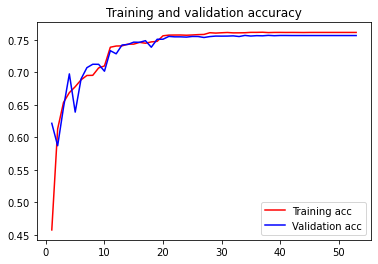

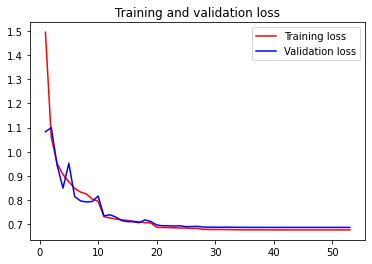

Accuracy: 0.7617083191871643
loss: 0.6770939826965332


In [19]:
# plot the loss and accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

print('Accuracy:', acc[-1])
print('loss:', loss[-1])

####References 
+ https://www.kaggle.com/crawford/diagnose-lung-disease-with-vgg16 
+ https://www.programcreek.com/python/example/92213/keras.applications.vgg16.VGG16 
+ http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html